# Prophet on Total Sales (Units Sold)

In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import logging
import itertools
%matplotlib inline

In [2]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [3]:
def calculate_smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    
    smape = 100 * np.mean(numerator / (denominator + 1e-10 ))
    return smape

In [4]:
df = pd.read_csv('../dataset/product_data.csv')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
total_df = df.groupby('Date')['UnitsSold'].sum().reset_index()
total_df.columns = ['ds', 'y']
total_df = total_df.sort_values('ds').reset_index(drop=True)

In [6]:
n = len(total_df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train_data = total_df.iloc[:train_end]
validation_data = total_df.iloc[train_end:val_end]
test_data = total_df.iloc[val_end:]

In [7]:
model = Prophet()
model.fit(train_data)

17:42:33 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing


## Validation

In [8]:
validation_forecast = model.predict(validation_data)

In [9]:
actual_values = np.array(validation_data['y'])
predicted_values = np.array(validation_forecast['yhat'])

In [10]:
validation_smape = calculate_smape(actual_values, predicted_values)
validation_smape

33.20753004803464

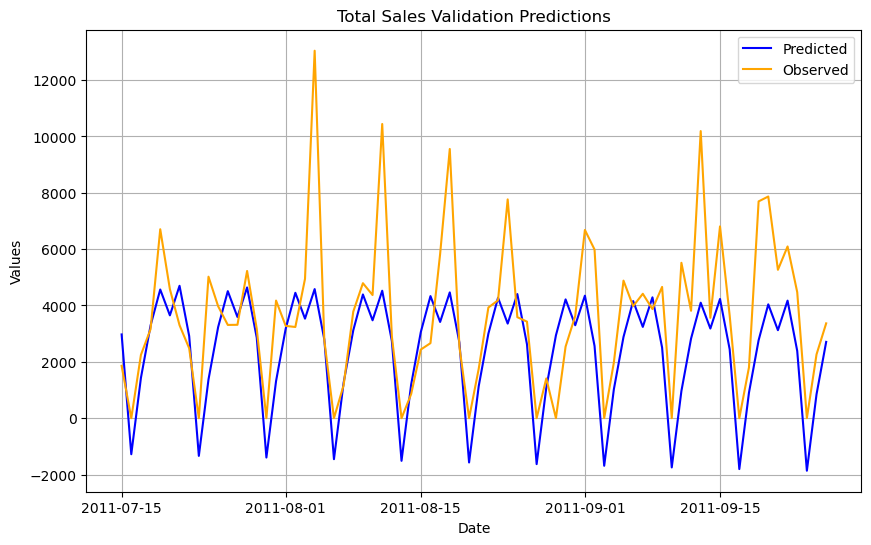

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(validation_data['ds']), validation_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(validation_data['ds']), validation_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Validation Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Test

In [12]:
test_forecast = model.predict(test_data)

In [13]:
actual_values = np.array(test_data['y'])
predicted_values = np.array(test_forecast['yhat'])

In [14]:
test_smape = calculate_smape(actual_values, predicted_values)
test_smape

41.22872729409501

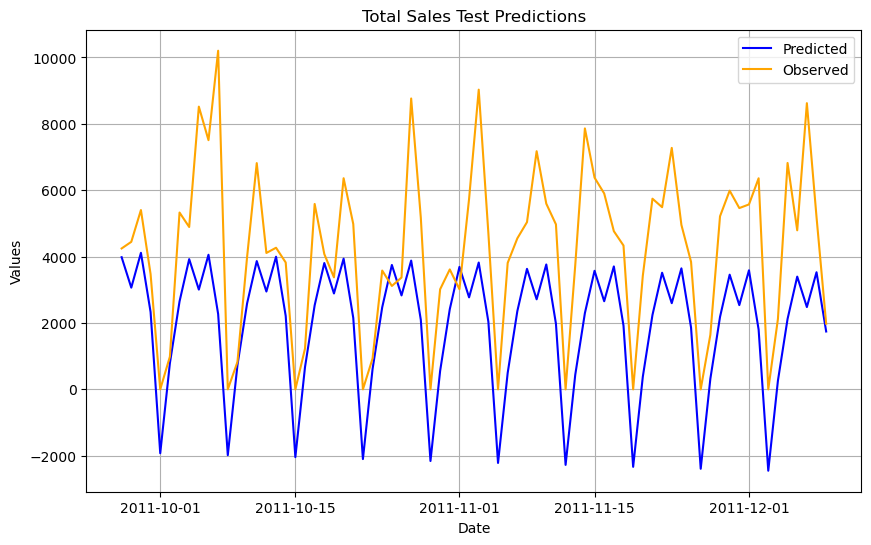

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

## Overall

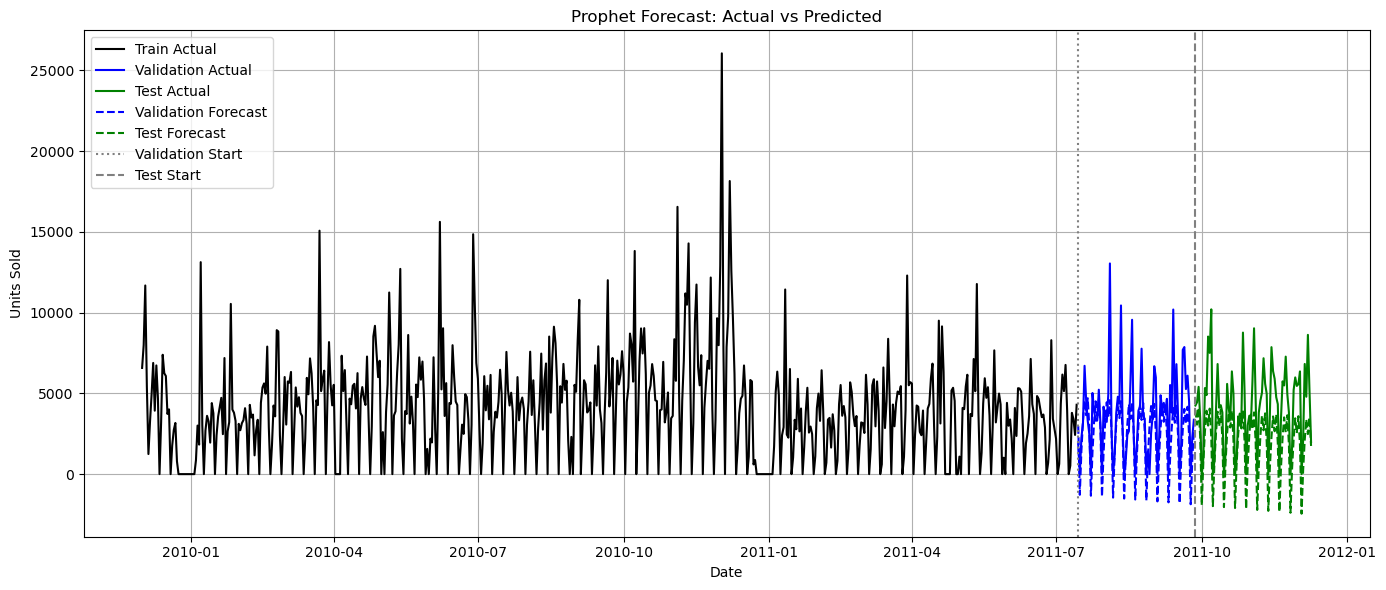

In [16]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(validation_forecast['ds'], validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(test_forecast['ds'], test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Tuning

In [17]:
param_grid = {
    "changepoint_prior_scale": [0.01, 0.05, 0.1, 0.2, 0.5],
    "seasonality_prior_scale": [0.05, 0.1, 0.5, 1, 5],
    "fourier_order": [3, 5, 10]
}

best_smape = float("inf")
best_params = None
best_model = None

In [18]:
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
validation_data = validation_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

In [19]:
# Grid search loop
for cps, sps, fo in itertools.product(
    param_grid["changepoint_prior_scale"],
    param_grid["seasonality_prior_scale"],
    param_grid["fourier_order"]
):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps
    )

    # Add custom monthly seasonality
    model.add_seasonality(name="monthly", period=30.5, fourier_order=fo)

    try:
        # Fit model
        model.fit(train_data[['ds', 'y']])

        # Predict on test
        future = validation_data[['ds']]
        forecast = model.predict(future)

        # Evaluate
        y_true = validation_data["y"]
        y_pred = forecast["yhat"]

        smape = calculate_smape(y_true, y_pred)

        print(f"cps={cps}, sps={sps}, fo={fo}: SMAPE={smape:.2f}%")

        if smape < best_smape:
            best_smape = smape
            best_params = (cps, sps, fo)
            best_model = model

    except Exception as e:
        print(f"⚠️ Skipping params (cps={cps}, sps={sps}, fo={fo}) due to error: {e}")

17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.05, fo=3: SMAPE=31.90%
cps=0.01, sps=0.05, fo=5: SMAPE=31.95%


17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.05, fo=10: SMAPE=31.86%
cps=0.01, sps=0.1, fo=3: SMAPE=32.01%


17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.1, fo=5: SMAPE=32.09%
cps=0.01, sps=0.1, fo=10: SMAPE=31.92%


17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.5, fo=3: SMAPE=31.95%
cps=0.01, sps=0.5, fo=5: SMAPE=32.03%


17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=0.5, fo=10: SMAPE=31.93%
cps=0.01, sps=1, fo=3: SMAPE=31.99%


17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing
17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=1, fo=5: SMAPE=31.83%
cps=0.01, sps=1, fo=10: SMAPE=31.97%


17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5, fo=3: SMAPE=32.01%
cps=0.01, sps=5, fo=5: SMAPE=31.92%


17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing


cps=0.01, sps=5, fo=10: SMAPE=32.02%
cps=0.05, sps=0.05, fo=3: SMAPE=32.79%


17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.05, fo=5: SMAPE=32.64%
cps=0.05, sps=0.05, fo=10: SMAPE=32.39%


17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=3: SMAPE=32.86%


17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.1, fo=5: SMAPE=32.47%
cps=0.05, sps=0.1, fo=10: SMAPE=32.45%


17:42:38 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.5, fo=3: SMAPE=32.61%


17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=0.5, fo=5: SMAPE=32.58%
cps=0.05, sps=0.5, fo=10: SMAPE=32.42%


17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=3: SMAPE=32.81%
cps=0.05, sps=1, fo=5: SMAPE=32.54%


17:42:39 - cmdstanpy - INFO - Chain [1] start processing
17:42:39 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=1, fo=10: SMAPE=32.49%
cps=0.05, sps=5, fo=3: SMAPE=32.76%


17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing


cps=0.05, sps=5, fo=5: SMAPE=32.54%
cps=0.05, sps=5, fo=10: SMAPE=32.42%


17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing
17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.05, fo=3: SMAPE=34.40%
cps=0.1, sps=0.05, fo=5: SMAPE=34.00%


17:42:40 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.05, fo=10: SMAPE=34.01%


17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.1, fo=3: SMAPE=34.86%


17:42:41 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.1, fo=5: SMAPE=34.07%


17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.1, fo=10: SMAPE=34.40%


17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.5, fo=3: SMAPE=34.26%


17:42:42 - cmdstanpy - INFO - Chain [1] done processing
17:42:42 - cmdstanpy - INFO - Chain [1] start processing
17:42:42 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=0.5, fo=5: SMAPE=34.16%


17:42:42 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=0.5, fo=10: SMAPE=34.00%


17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=1, fo=3: SMAPE=34.08%


17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=1, fo=5: SMAPE=34.23%


17:42:43 - cmdstanpy - INFO - Chain [1] start processing


cps=0.1, sps=1, fo=10: SMAPE=34.30%


17:42:43 - cmdstanpy - INFO - Chain [1] done processing
17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5, fo=3: SMAPE=34.42%


17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5, fo=5: SMAPE=34.27%


17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing


cps=0.1, sps=5, fo=10: SMAPE=33.95%


17:42:44 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.05, fo=3: SMAPE=34.81%


17:42:44 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.05, fo=5: SMAPE=34.07%


17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.05, fo=10: SMAPE=34.14%


17:42:45 - cmdstanpy - INFO - Chain [1] done processing
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.1, fo=3: SMAPE=34.08%


17:42:46 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.1, fo=5: SMAPE=34.43%


17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.1, fo=10: SMAPE=34.16%


17:42:46 - cmdstanpy - INFO - Chain [1] done processing
17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.5, fo=3: SMAPE=35.08%


17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:42:46 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=0.5, fo=5: SMAPE=34.53%


17:42:47 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=0.5, fo=10: SMAPE=34.38%


17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=1, fo=3: SMAPE=35.31%


17:42:47 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=1, fo=5: SMAPE=34.73%


17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=1, fo=10: SMAPE=34.60%


17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:48 - cmdstanpy - INFO - Chain [1] done processing


cps=0.2, sps=5, fo=3: SMAPE=35.74%


17:42:48 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=5, fo=5: SMAPE=34.52%


17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:48 - cmdstanpy - INFO - Chain [1] start processing


cps=0.2, sps=5, fo=10: SMAPE=33.77%


17:42:48 - cmdstanpy - INFO - Chain [1] done processing
17:42:49 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.05, fo=3: SMAPE=33.72%


17:42:49 - cmdstanpy - INFO - Chain [1] done processing
17:42:49 - cmdstanpy - INFO - Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.05, fo=5: SMAPE=33.68%


17:42:49 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.05, fo=10: SMAPE=33.63%


17:42:49 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=0.1, fo=3: SMAPE=33.28%


17:42:50 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.1, fo=5: SMAPE=33.50%


17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.1, fo=10: SMAPE=33.41%


17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.5, fo=3: SMAPE=33.33%


17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:51 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.5, fo=5: SMAPE=33.08%


17:42:51 - cmdstanpy - INFO - Chain [1] done processing
17:42:51 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=0.5, fo=10: SMAPE=33.06%


17:42:51 - cmdstanpy - INFO - Chain [1] done processing
17:42:51 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=1, fo=3: SMAPE=33.48%


17:42:51 - cmdstanpy - INFO - Chain [1] done processing
17:42:52 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=1, fo=5: SMAPE=33.32%


17:42:52 - cmdstanpy - INFO - Chain [1] done processing
17:42:52 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=1, fo=10: SMAPE=32.90%


17:42:52 - cmdstanpy - INFO - Chain [1] done processing
17:42:52 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=5, fo=3: SMAPE=33.25%


17:42:53 - cmdstanpy - INFO - Chain [1] start processing


cps=0.5, sps=5, fo=5: SMAPE=33.08%


17:42:53 - cmdstanpy - INFO - Chain [1] done processing


cps=0.5, sps=5, fo=10: SMAPE=33.00%


In [20]:
print(f"\n✅ Best Parameters: changepoint_prior_scale={best_params[0]}, "
      f"seasonality_prior_scale={best_params[1]}, fourier_order={best_params[2]}")
print(f"📉 Best SMAPE on Validation Set: {best_smape:.2f}%")

best_test_forecast = best_model.predict(test_data[["ds"]])
best_validation_forecast = best_model.predict(validation_data[["ds"]])


✅ Best Parameters: changepoint_prior_scale=0.01, seasonality_prior_scale=1, fourier_order=5
📉 Best SMAPE on Validation Set: 31.83%


In [23]:
test_smape = calculate_smape(test_data[["y"]], best_test_forecast['yhat'])
test_smape

36.60719624664806

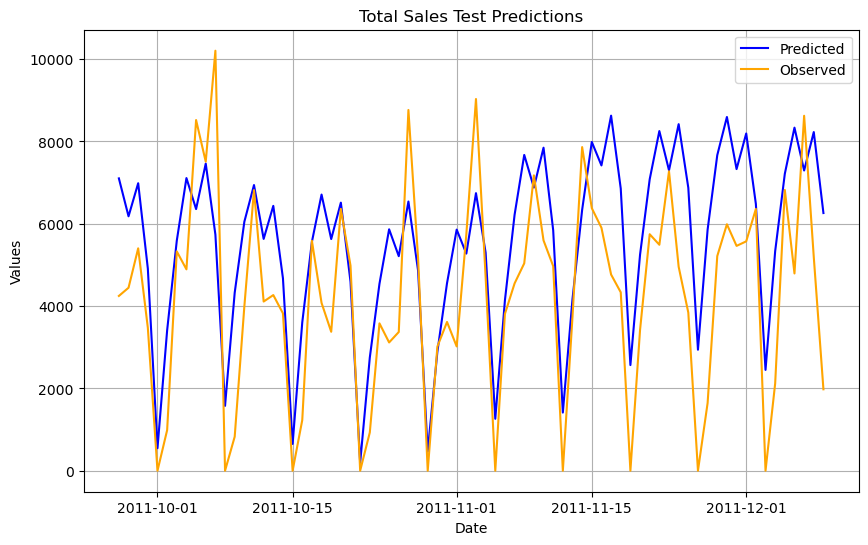

In [147]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(test_data['ds']), best_test_forecast['yhat'], label='Predicted', color='blue')
plt.plot(pd.to_datetime(test_data['ds']), test_data['y'], label='Observed', color='orange')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Total Sales Test Predictions')
plt.legend()
plt.grid(True)
plt.show()

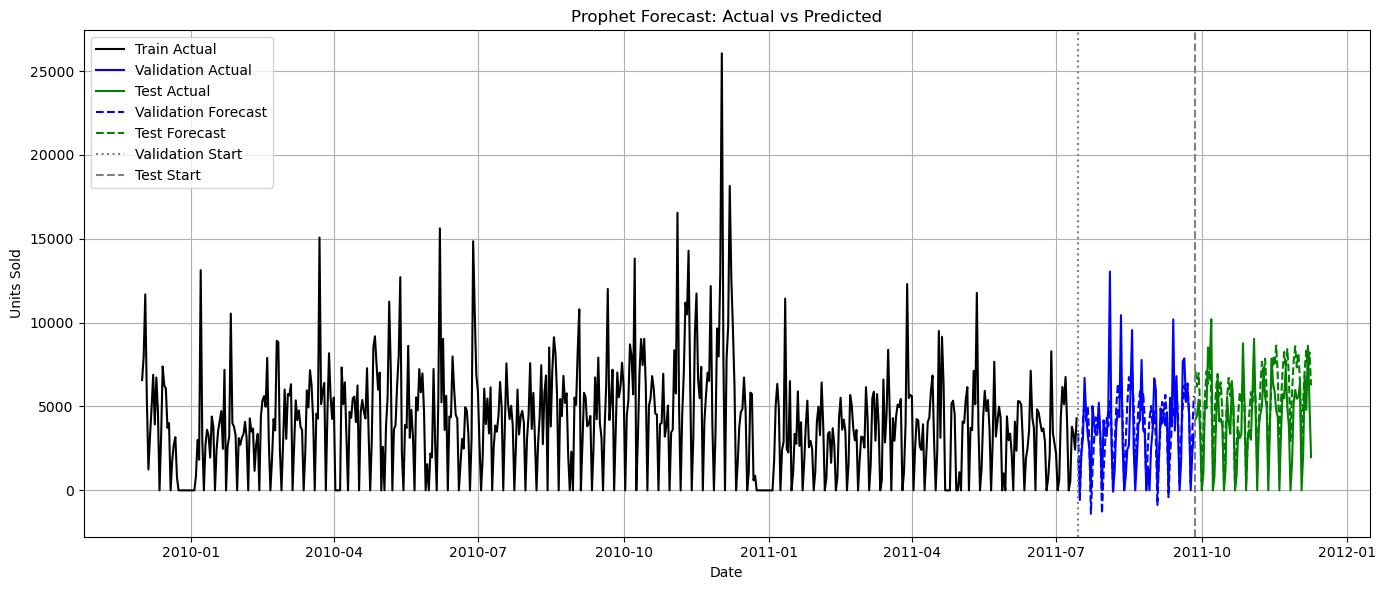

In [148]:
plt.figure(figsize=(14, 6))

plt.plot(train_data['ds'], train_data['y'], label='Train Actual', color='black')
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Actual', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Test Actual', color='green')

plt.plot(best_validation_forecast['ds'], best_validation_forecast['yhat'], label='Validation Forecast', color='blue', linestyle='--')
plt.plot(best_test_forecast['ds'], best_test_forecast['yhat'], label='Test Forecast', color='green', linestyle='--')

plt.axvline(x=validation_data['ds'].min(), color='gray', linestyle=':', label='Validation Start')
plt.axvline(x=test_data['ds'].min(), color='gray', linestyle='--', label='Test Start')

plt.title('Prophet Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
